In [1]:
import sys
import os
import os.path
from pathlib import Path
os.chdir(Path(os.path.realpath('__file__')).parents[1])
sys.path.append(Path(os.path.realpath('__file__')).parents[1])

In [232]:
import pandas as pd
import numpy as np
from scipy import stats
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
#import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import joblib
import json
import sys
import math
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import itertools

from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV

run = "run5" # run5 is causal estimation
score = "" # "": marisa's score
verbose = False
example = False # "1159-GDSC2" # False
model_type = "grf"

In [271]:
# use one parameter dict
if len(sys.argv)!=2:
    argument = ['-',1]
else:
    print('cmd entry:', sys.argv)
    argument = sys.argv
which_run = int(argument[1]) - 1
print("emtpb: Parallel run "+str(which_run))

### costum
#which_run = 0
which_run = 24
###

print("emtpb: Updated manual parallel run "+str(which_run))

EMTscores = pd.read_csv("metadata/EMTscores"+str(score)+".csv")
cancertypes = np.concatenate((['PANCAN'], EMTscores['TCGA Desc'].unique()))
preds_dir = "metadata/"+run+"/predictions/"+cancertypes[which_run]+"/"
model_dir = "metadata/"+run+"/models/"+cancertypes[which_run]+"/"
os.makedirs(preds_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

mut = pd.read_csv("metadata/matrix_mut_"+cancertypes[which_run]+".csv")
resp_full = pd.read_csv("metadata/matrix_resp.csv")
cols = resp_full.columns[resp_full.columns.str.contains('GDSC')]

emtpb: Parallel run 0
emtpb: Updated manual parallel run 24


In [444]:
# Functions
def t_test(x, vadj=7.25): # 7.25 for 5x5 cv
    x = x[~np.isnan(x)]
    n = len(x)
    stat = np.mean(x) / np.sqrt(np.var(x)/n*vadj)
    return 2 * stats.t.sf(np.abs(stat), n-1)


def run_model_cv(X, y, outer_seed, inner_seed, model_dir, preds_dir, names, which_index, outer_folds = 5, inner_folds = 5, repeats = 5, baseline = False, save_models = False, model_type = "eln", check_for_trained = True, min_samples = 25):
    
    # predictions save path and check if its exists already
    preds_filename = os.path.join(preds_dir, f"predictions_{model_type}_{which_index}_{baseline}.csv")
    if check_for_trained:
        if Path(preds_filename).exists():
            print("emtpb: iteration "+str(index)+" already exists... skipping...")
            return
    
    # remove interesting variable for baseline
    if baseline:
        X = np.delete(X, 0, axis=1)
    
    # initialize list of all preds
    all_all_predictions = []
    all_all_truth = []
    all_all_folds = []
   
    # Initialize names
    names = pd.DataFrame(names)
    names = pd.concat([names]*repeats, ignore_index = True)
    
    # check size of X,y and save placeholder
    if mat.shape[0] < min_samples: # minimum 25 samples needed (5 test samples in outer cv and 4 in inner)
        print("Amount of columns is only "+str(mat.shape[0])+"... skipping")
        names.to_csv(preds_filename, index=False)
        return
    
    # initialize the outer cross-validation
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=outer_seed)

    # initialize the inner cross-validation
    inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=inner_seed)

    # repeat the outer cross-validation 5 times
    for repeat in range(repeats):
        
        # initialize the list to store the predictions
        all_predictions = []
        all_truth = []
        all_folds = []

        # set the seed for the outer cross-validation
        outer_cv.random_state = outer_seed + repeat

        # loop through the splits of the outer cross-validation
        for i, (train_index, test_index) in enumerate(outer_cv.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # initialize the model
            
            # elastic net
            if model_type == "eln":
                model = ElasticNetCV(l1_ratio=[0.01, .1, .5, .9, .95, 1],
                                     cv=inner_cv,
                                     random_state=inner_seed,
                                     tol=0.01)
                

            # random forest
            if model_type == "rf":
                model = RandomForestRegressor(random_state=inner_seed)
                
                
            # neural network
            if model_type == "mlp":
                model = MLPRegressor(max_iter=1000,
                                     random_state=inner_seed)
                # Define the hyperparameters to search over
                
                hidden_layer_sizes = [10, 50, 100, 150, 200]
                n_layers = [2, 3 , 4]
                layer_permutations = list(itertools.chain(*[itertools.permutations(hidden_layer_sizes, n) for n in n_layers]))
                
                param_grid = {
                    'hidden_layer_sizes': layer_permutations
                    #'activation': ['relu'] # 'identity', 'logistic', 'tanh', 
                    #'learning_rate_init': [0.001]
                }
                grid_search = RandomizedSearchCV(model, param_grid, cv=inner_folds, n_iter = 10, random_state = i+repeat*35)
                grid_search.fit(X, y)
                model = grid_search.best_estimator_
                
                # Get the best hyperparameters
                print(grid_search.best_params_)
                
                
            ############################    
            if model_type in ["eln","rf","mlp"]:
                
                # fit the model on the training data
                model.fit(X_train, y_train)
                
                # make predictions on the test set
                y_pred = model.predict(X_test)
                
                # save the predictions
                all_predictions.append(y_pred)
                all_truth.append(y_test)
                all_folds.append([i]*len(y_test))
                
            # causal modelling
            if model_type in ["grf"]:

                basemodel = ElasticNetCV(l1_ratio=[0.01, .1, .5, .9, .95, 1],
                                         cv=inner_cv,
                                         random_state=inner_seed,
                                         tol=0.01)
                
                # fit the model on the training data
                np.random.seed(123)
                model = CausalForestDML(discrete_treatment=False, random_state=123, model_y=basemodel, model_t=basemodel)
 
                # ignore train and test because we don't need it here
                tmp = np.array(response) # np.random.permutation(
                X_red = np.delete(X,(0), axis=1) #
            
                # fit model
                model.fit(y, X[:,0], X=X_red) #model.fit(tmp, mat[:,0], X=matt)
                summary = model.const_marginal_ate_inference(X_red) #, model.const_marginal_ate_interval(np.delete(mat,(0), axis=1))
                #print(summary)
                #print(summary.pvalue())

                
                # make predictions on the test set
                #y_pred = model.predict(X_test)
                y_pred = model.effect(X_red)
                
                # save the predictions
                all_predictions.append(y_pred)
                all_truth.append(y)
                all_folds.append([np.array2string(np.array([summary.pvalue(),model.const_marginal_ate(X_red),model.const_marginal_ate_interval(X_red)], dtype=object))]*len(y)) # transformback with: transformed_array = np.fromstring(my_array.replace('\n', '').replace(' ', ',').replace(',,',',').replace('(','').replace(')','')[1:-1], sep=',')
                #all_folds.append([i]*len(y_test))
                
                break # exit the loop after causal estimation
                
            # save the predictions
            #all_predictions.append(y_pred)
            #all_truth.append(y_test)
            #all_folds.append([i]*len(y_test))

            # save the model
            model_filename = os.path.join(model_dir, f"model_{model_type}_{which_index}_{baseline}_{repeat}_{i}.joblib")
            if save_models:
                joblib.dump(model, model_filename)

        # concatenate all the predictions from cv
        all_predictions = np.concatenate(all_predictions)
        all_truth = np.concatenate(all_truth)
        all_folds = np.concatenate(all_folds)
        
        # save the cv results and append to resampling
        all_all_predictions.append(all_predictions)
        all_all_truth.append(all_truth)
        all_all_folds.append(all_folds)
    
    # concatenate all the predictions
    all_all_predictions = np.concatenate(all_all_predictions)
    all_all_truth = np.concatenate(all_all_truth)
    all_all_folds = np.concatenate(all_all_folds)
    
    names["preds"] = all_all_predictions
    names["truth"] = all_all_truth#np.concatenate([y]*repeats)
    names["repeat"] = np.concatenate([[i]*len(y) for i in range(repeats)])
    names["folds"] = all_all_folds
    names["repeatfold"] = names["repeat"].astype(str) + names["folds"].astype(str)
    
    # save predictions 
    names.to_csv(preds_filename, index=False)
    return names

In [445]:
# benchmark
for index in range(len(cols)):
    
    ### costum
    #index = 0
    ###
    if not not example:
        index = np.where(cols == "1559-GDSC2")[0][0]
    
    print("emtpb: modelling iteration "+str(index)+"...")
    #index = np.where(cols == "1559-GDSC2")[0][0]

    # get one response column
    resp = resp_full.copy()
    resp = resp[["COSMIC ID","TCGA Desc",cols[index]]]
    mat = pd.merge(EMTscores, resp, how='outer')
    if cancertypes[which_run] != "PANCAN":
        mat = mat[mat['TCGA Desc'] == cancertypes[which_run]]
    mat = pd.merge(mat, mut, how='outer')
    mat = pd.get_dummies(mat)
    mat_df = mat
    print("empb: shape before removing nan is "+str(mat.shape))
    mat.dropna(inplace=True)
    print("empb: shape after removing nan is "+str(mat.shape))
    if mat.shape[0] == 0:
        df = pd.DataFrame([[0]*mat.shape[1]],columns=mat.columns)
        mat = mat.append(df, ignore_index=True)
    names = mat['COSMIC ID']
    mat.drop(columns=['COSMIC ID'], inplace=True)
    response = mat.iloc[:,1] # mat.iloc[:,1] (drug response), # mat.iloc[:,0] (emt score)
    mat = mat.drop(mat.columns[1], axis=1)
    scale = StandardScaler()
    mat = scale.fit_transform(mat)

    for baseline in [True,False]: # [True, False]
        if model_type == "grf" and baseline == True:
            continue # skip baseline calcs for causal modelling
        df = run_model_cv(
            X = mat,
            y = np.array(response),
            outer_seed = 53+53, 
            inner_seed = 53,
            model_dir = model_dir,
            preds_dir = preds_dir,
            names = names,
            which_index = index,
            repeats = (1 if model_type == 'grf' else 5), # <------- SET TO 5
            baseline = baseline,
            model_type = model_type,
            save_models = False,
            check_for_trained = True,
            outer_folds = 5
        )

    if verbose:
        test = pd.read_csv(preds_dir+"predictions_"+str(model_type)+"_"+str(index)+"_False.csv")
        perfalse = np.array(test.groupby("repeatfold")[['preds','truth']].corr().iloc[1::2,0])
        perfalse[np.isnan(perfalse)] = 0
        print(perfalse)
        print(np.mean(perfalse)) # 
        test = pd.read_csv(preds_dir+"predictions_"+str(model_type)+"_"+str(index)+"_True.csv")
        pertrue = np.array(test.groupby("repeatfold")[['preds','truth']].corr().iloc[1::2,0])
        pertrue[np.isnan(pertrue)] = 0
        print(pertrue)
        print(np.mean(pertrue)) #
        print("t-test p="+str(t_test(perfalse-pertrue)))
        
    if not not example:
        break

emtpb: modelling iteration 0...
empb: shape before removing nan is (55, 97)
empb: shape after removing nan is (16, 97)
emtpb: iteration 0 already exists... skipping...
emtpb: modelling iteration 1...
empb: shape before removing nan is (55, 97)
empb: shape after removing nan is (15, 97)
emtpb: iteration 1 already exists... skipping...
emtpb: modelling iteration 2...
empb: shape before removing nan is (55, 97)
empb: shape after removing nan is (17, 97)
emtpb: iteration 2 already exists... skipping...
emtpb: modelling iteration 3...
empb: shape before removing nan is (55, 97)
empb: shape after removing nan is (17, 97)
emtpb: iteration 3 already exists... skipping...
emtpb: modelling iteration 4...
empb: shape before removing nan is (55, 97)
empb: shape after removing nan is (17, 97)
emtpb: iteration 4 already exists... skipping...
emtpb: modelling iteration 5...
empb: shape before removing nan is (55, 97)
empb: shape after removing nan is (17, 97)
emtpb: iteration 5 already exists... skip

In [9]:
print("emt_pb: done modelling "+cancertypes[which_run]+".")

emt_pb: done modelling SKCM.


In [ ]:
#np.array(resp.iloc[:,2])
#np.array(EMTscores.iloc[:,2])

In [ ]:
#Check feature importances
#m = joblib.load("metadata/run1/models/SKCM/model_513_False_0_0.joblib")

In [209]:
# Test methods
from econml.dml import CausalForestDML, SparseLinearDML, LinearDML
from econml.grf import CausalForest
from econml.orf import DMLOrthoForest
from econml.dr import ForestDRLearner
from econml.sklearn_extensions.linear_model import WeightedLassoCV

"""
GRF causal forest
model = CausalForest(random_state=123)
model.fit(y=np.array(response)[11:52,], T=mat[11:52,0], X=np.delete(mat,(0), axis=1)[11:52,:])
print(model.predict(X=np.delete(mat,(0), axis=1)[1:10,:]))
#print(model.effect(np.delete(mat,(0), axis=1)[1:10,:]))
#print(model.effect(np.delete(mat,(0), axis=1)[:,:]))
#print(model.const_marginal_ate(np.delete(mat,(0), axis=1)[:,:]))
#print(scipy.stats.pearsonr(response,mat[:,0]))
print(model.feature_importances())
"""

inner_cv = KFold(n_splits=5, shuffle=True, random_state=53)
basemodel = ElasticNetCV(l1_ratio=[0.01, .1, .5, .9, .95, 1],
                     #cv=inner_cv,
                     random_state=123, tol=0.01)

#double ML causal forest, but with double regression.....
#model = ForestDRLearner(discrete_treatment=False, random_state=123, n_jobs=1, model_propensity=basemodel, model_regression=basemodel) # only for categorical treatments
#model = DMLOrthoForest(discrete_treatment=False, random_state=123, model_Y=basemodel, model_T=basemodel) # model_y=MLPRegressor(hidden_layer_sizes=(200, 150, 100, 10)), model_t=MLPRegressor(hidden_layer_sizes=(200, 150, 100, 10))) #
model = CausalForestDML(discrete_treatment=False, random_state=123, model_y=basemodel, model_t=basemodel) #model_y=MLPRegressor(hidden_layer_sizes=(200, 150, 100, 10)), model_t=MLPRegressor(hidden_layer_sizes=(200, 150, 100, 10))) #
tmp = np.array(response) # np.random.permutation(
matt = mat[:,:] # np.delete(mat,(0), axis=1) #
model.fit(tmp, mat[:,0], X=matt) #model.fit(tmp, mat[:,0], X=matt)
summary = model.const_marginal_ate_inference(matt) #, model.const_marginal_ate_interval(np.delete(mat,(0), axis=1))
print(summary)
print(summary.pvalue())
effects = model.effect(matt)
print(effects)
#model.fit(tmp[11:52,], mat[11:52,0], X=matt[11:52,:])
#print(model.const_marginal_ate(matt[11:52,:]), model.const_marginal_ate_interval(np.delete(mat,(0), axis=1)[11:52,:]))
#print(model.const_marginal_ate_inference(matt[1:10,:]).summary_frame())
#print(model.effect(matt[1:10,:]))


"""
# X-learner
from econml.metalearners import XLearner
from sklearn.linear_model import LinearRegression

inner_cv = KFold(n_splits=5, shuffle=True, random_state=123)
model = XLearner(models=ElasticNetCV())
tmp = np.array(response) # np.random.permutation(
model.fit(tmp, mat[:,0], X=np.delete(mat,(0), axis=1))
#model.fit(tmp[11:52,], mat[11:52,0], X=np.delete(mat,(0), axis=1)[11:52,:])
#print(model.const_marginal_ate(np.delete(mat,(0), axis=1)[11:52,:]), model.const_marginal_ate_interval(np.delete(mat,(0), axis=1)[11:52,:]))
#print(model.const_marginal_ate(np.delete(mat,(0), axis=1)[1:10,:]), model.const_marginal_ate_interval(np.delete(mat,(0), axis=1)[1:10,:]))
print(model.const_marginal_ate(X=np.delete(mat,(0), axis=1)))#, model.const_marginal_ate_interval(X=np.delete(mat,(0), axis=1)))
"""

               Uncertainty of Mean Point Estimate              
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
   442.209     155.592 2.842  0.004       137.255       747.163
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
   29.911         395.998         487.031
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
     158.441        103.957        746.504
------------------------------------------

Note: The stderr_mean is a conservative upper bound.
0.004481571080677497
[487.03103857 416.90644848 416.90644848 426.52973841 416.90644848
 394.86488259 398.98569888 464.97462955 416.90644848 434.66954173
 446.53554974 416.90644848 484.89910363 479.85938838 464.97462955
 464.97462955 464.97462955 490.67818204 398.98569888 464.97462955
 416.90644848 468.5740

'\n# X-learner\nfrom econml.metalearners import XLearner\nfrom sklearn.linear_model import LinearRegression\n\ninner_cv = KFold(n_splits=5, shuffle=True, random_state=123)\nmodel = XLearner(models=ElasticNetCV())\ntmp = np.array(response) # np.random.permutation(\nmodel.fit(tmp, mat[:,0], X=np.delete(mat,(0), axis=1))\n#model.fit(tmp[11:52,], mat[11:52,0], X=np.delete(mat,(0), axis=1)[11:52,:])\n#print(model.const_marginal_ate(np.delete(mat,(0), axis=1)[11:52,:]), model.const_marginal_ate_interval(np.delete(mat,(0), axis=1)[11:52,:]))\n#print(model.const_marginal_ate(np.delete(mat,(0), axis=1)[1:10,:]), model.const_marginal_ate_interval(np.delete(mat,(0), axis=1)[1:10,:]))\nprint(model.const_marginal_ate(X=np.delete(mat,(0), axis=1)))#, model.const_marginal_ate_interval(X=np.delete(mat,(0), axis=1)))\n'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


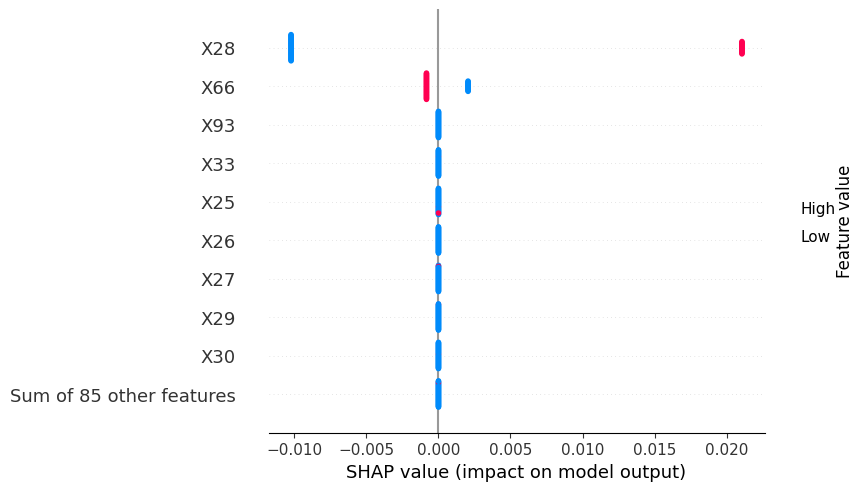

WT1_mut cnaSKCM4


In [198]:
import shap
%matplotlib inline
shap_values = model.shap_values(matt) # takes ages for Ortho
shap.plots.beeswarm(shap_values['Y0']['T0'])
print(mat_df.columns[2+29], mat_df.columns[2+66])

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


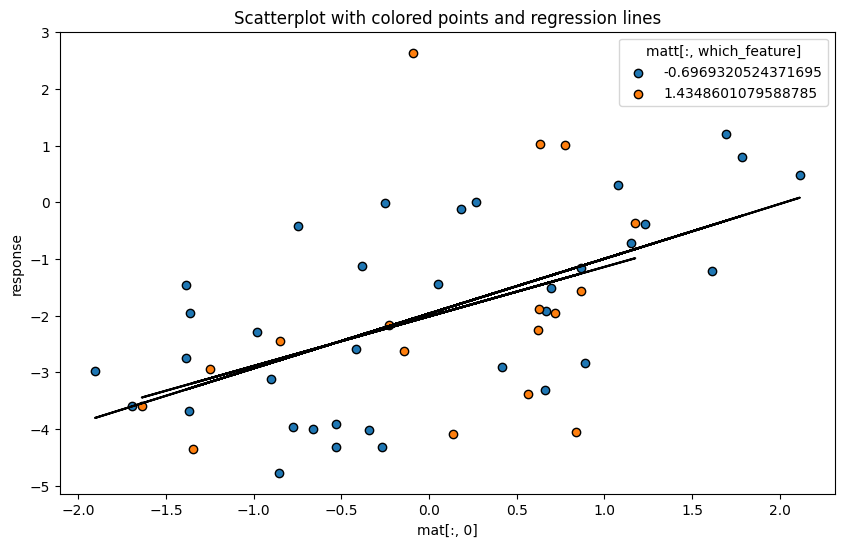

In [199]:
# plot scatter plot
which_feature = 28
from sklearn.linear_model import LinearRegression

# create colormap for points
cmap = plt.cm.get_cmap('viridis', np.unique(matt[:, which_feature]).size)

# create scatterplot with colored points
fig, ax = plt.subplots(figsize=(10, 6))
for i, label in enumerate(np.unique(matt[:, which_feature])):
    ax.scatter(mat[matt[:, which_feature] == label, 0], response[matt[:, which_feature] == label], label=label, cmap=cmap, edgecolors='black')

# add regression lines for each group
for i, label in enumerate(np.unique(matt[:, which_feature])):
    m = LinearRegression().fit(mat[matt[:, which_feature] == label, 0].reshape(-1, 1), response[matt[:, which_feature] == label])
    ax.plot(mat[matt[:, which_feature] == label, 0], m.predict(mat[matt[:, which_feature] == label, 0].reshape(-1, 1)), color='black')

# set labels and legend
ax.set_xlabel('mat[:, 0]')
ax.set_ylabel('response')
ax.set_title('Scatterplot with colored points and regression lines')
ax.legend(title='matt[:, which_feature]')

plt.show()

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


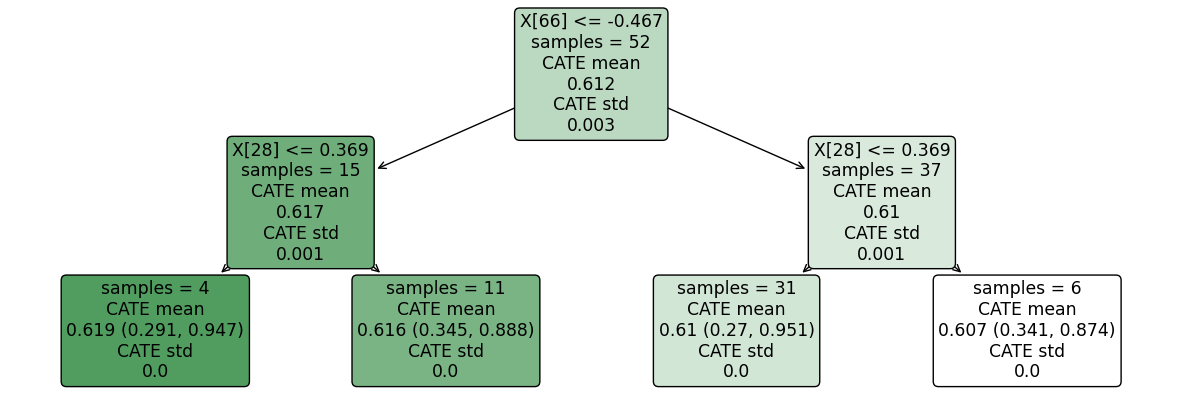

In [200]:
# INTERPRETATION
%matplotlib inline
from econml.cate_interpreter import SingleTreeCateInterpreter
import matplotlib.pyplot as plt
import matplotlib
#
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2)
intrp.interpret(model, matt)
plt.figure(figsize=(15, 5))
intrp.plot()
plt.show()

In [ ]:
'''
X = mat
y = np.array(response)
outer_seed = 53+53
inner_seed = 53
which_index = index
repeats = 1
baseline = True
save_models = False
check_for_trained = False
outer_folds = 5
inner_folds = 5
min_samples = 5



# predictions save path and check if its exists already
### costum
index = 0
###
if not not example:
    index = np.where(cols == "1559-GDSC2")[0][0]

print("emtpb: modelling iteration "+str(index)+"...")
#index = np.where(cols == "1559-GDSC2")[0][0]

# get one response column
resp = resp_full.copy()
resp = resp[["COSMIC ID","TCGA Desc",cols[index]]]
mat = pd.merge(EMTscores, resp, how='outer')
if cancertypes[which_run] != "PANCAN":
    mat = mat[mat['TCGA Desc'] == cancertypes[which_run]]
mat = pd.merge(mat, mut, how='outer')
mat = pd.get_dummies(mat)
mat_df = mat
print("empb: shape before removing nan is "+str(mat.shape))
mat.dropna(inplace=True)
print("empb: shape after removing nan is "+str(mat.shape))
if mat.shape[0] == 0:
    df = pd.DataFrame([[0]*mat.shape[1]],columns=mat.columns)
    mat = mat.append(df, ignore_index=True)
names = mat['COSMIC ID']
mat.drop(columns=['COSMIC ID'], inplace=True)
response = mat.iloc[:,1] # mat.iloc[:,1] (drug response), # mat.iloc[:,0] (emt score)
mat = mat.drop(mat.columns[1], axis=1)
scale = StandardScaler()
mat = scale.fit_transform(mat)


preds_filename = os.path.join(preds_dir, f"predictions_{model_type}_{which_index}_{baseline}.csv")
if check_for_trained:
    if Path(preds_filename).exists():
        print("emtpb: iteration "+str(index)+" already exists... skipping...")

# remove interesting variable for baseline
if baseline:
    X = np.delete(X, 0, axis=1)

# initialize list of all preds
all_all_predictions = []
all_all_truth = []
all_all_folds = []

# Initialize names
names = pd.DataFrame(names)
names = pd.concat([names]*repeats, ignore_index = True)

# check size of X,y and save placeholder
if mat.shape[0] < min_samples: # minimum 25 samples needed (5 test samples in outer cv and 4 in inner)
    print("Amount of columns is only "+str(mat.shape[0])+"... skipping")
    names.to_csv(preds_filename, index=False)

# initialize the outer cross-validation
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=outer_seed)

# initialize the inner cross-validation
inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=inner_seed)


    
# repeat the outer cross-validation 5 times
for repeat in range(repeats):

    # initialize the list to store the predictions
    all_predictions = []
    all_truth = []
    all_folds = []

    # set the seed for the outer cross-validation
    outer_cv.random_state = outer_seed + repeat

    # loop through the splits of the outer cross-validation
    for i, (train_index, test_index) in enumerate(outer_cv.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # initialize the model
        if model_type == "eln":
            model = ElasticNetCV(l1_ratio=[0.01, .1, .5, .9, .95, 1],
                                 cv=inner_cv,
                                 random_state=inner_seed,
                                 tol=0.01
                                )
        if model_type == "rf":
            model = RandomForestRegressor(random_state=inner_seed)

        if model_type == "mlp":
            model = MLPRegressor(max_iter=1000,
                                 random_state=inner_seed)
            # Define the hyperparameters to search over

            hidden_layer_sizes = [10, 50, 100, 150, 200]
            n_layers = [2, 3 , 4]
            layer_permutations = list(itertools.chain(*[itertools.permutations(hidden_layer_sizes, n) for n in n_layers]))

            param_grid = {
                'hidden_layer_sizes': layer_permutations
                #'activation': ['relu'] # 'identity', 'logistic', 'tanh', 
                #'learning_rate_init': [0.001]
            }
            grid_search = RandomizedSearchCV(model, param_grid, cv=inner_folds, n_iter = 10, random_state = i+repeat*35)
            grid_search.fit(X, y)
            model = grid_search.best_estimator_

            # Get the best hyperparameters
            print(grid_search.best_params_)

        # fit the model on the training data
        model.fit(X_train, y_train)

        # make predictions on the test set
        y_pred = model.predict(X_test)

        # save the predictions
        all_predictions.append(y_pred)
        all_truth.append(y_test)
        all_folds.append([i]*len(y_test))

    # concatenate all the predictions from cv
    all_predictions = np.concatenate(all_predictions)
    all_truth = np.concatenate(all_truth)
    all_folds = np.concatenate(all_folds)

    # save the cv results and append to resampling
    all_all_predictions.append(all_predictions)
    all_all_truth.append(all_truth)
    all_all_folds.append(all_folds)

# concatenate all the predictions
all_all_predictions = np.concatenate(all_all_predictions)
all_all_truth = np.concatenate(all_all_truth)
all_all_folds = np.concatenate(all_all_folds)

print(all_all_predictions)
print(all_all_truth)
'''